# Gesture Recognition
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly.

In [1]:
# importing necessary libraries
import numpy as np
import imageio
import random
from skimage.transform import resize
import datetime
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

batch_size_Conv3d = 32 #experiment with the batch size
img_height_Conv3d = 75
img_width_Conv3d = 75
batch_size_CNN_RNN = 16 #experiment with the batch size
img_height_CNN_RNN = 224
img_width_CNN_RNN = 224

# size of train_doc
print('Number of videos for training',len(train_doc))
# Checking a row of training data
print(train_doc[0])
# size of val_doc
print('\n Number of videos for validation',len(val_doc))
# Checking a row of validation data
print(val_doc[0])

Number of videos for training 663
WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1


 Number of videos for validation 100
WIN_20180926_17_24_20_Pro_Thumbs_Down_new;Thumbs_Down_new;3



##### Initial analysis to understand the spead of the data-  

In [4]:
labels = []
for i in train_doc:
    labels.append((i.split(';')[2]).split('\n')[0])
print("Percentage of left swipe: ", labels.count('0')*(100/663))
print("Percentage of right swipe: ", labels.count('1')*(100/663))
print("Percentage of stop: ", labels.count('2')*(100/663))
print("Percentage of thumbs down: ", labels.count('3')*(100/663))
print("Percentage of thumbs up: ", labels.count('4')*(100/663))

Percentage of left swipe:  20.51282051282051
Percentage of right swipe:  20.66365007541478
Percentage of stop:  19.6078431372549
Percentage of thumbs down:  20.66365007541478
Percentage of thumbs up:  18.55203619909502


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

#### Note that the images are sorted in order so that the sequence of the images are correct before they are fed to the model.
Image sorting is done via - "imges = sorted(imgs, key=lambda b: b[-9:-4]) " 
Images should be fed in sorted manner to the model so that model can understand and interpret the sequence properly.

In [5]:
def generator(source_path, folder_list, batch_size, y, z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [a for a in range(30) if a%2 == 0] #create a list of image numbers you want to use for a particular video
  ## We are taking every alternate image and hence as set of 15 images will be used.
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(np.floor(len(t) / batch_size)) # calculate the number of batches
        x = len(img_idx)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                imges = sorted(imgs, key=lambda b: b[-9:-4]) #Sort the images in order.
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imges[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape ## 360x360 and 120x160
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    height, width, depth = image.shape
                    if height == width:
                        image = resize(image, (y, z))
                    else:
                        if height < width:
                            image = image[:, int(np.floor((width - height)/2)):width - int(np.floor(((width - height)/2))), :]
                            image = resize(image, (y, z))
                        else:
                            image = image[int(np.floor((height - width)/2)):height - int(np.floor(((height - width)/2))), :, :]
                            image = resize(image, (y, z))
                    
                    batch_data[folder,idx,:,:,0] = (image[:, :, 0] - image[:, :, 0].mean())/image[:, :, 0].std() #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:, :, 1] - image[:, :, 1].mean())/image[:, :, 1].std() #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:, :, 2] - image[:, :, 2].mean())/image[:, :, 2].std() #normalise and feed in the image 
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(train_doc) % batch_size) != 0:
            extra_batch_size = len(t)-(int(np.floor(len(t) / batch_size))*batch_size)
            batch_data = np.zeros((extra_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((extra_batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(extra_batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                imges = sorted(imgs, key=lambda b: b[-9:-4])#Sort the images in order.
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imges[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape ## 360x360 and 120x160
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    height, width, depth = image.shape
                    if height == width:
                        image = resize(image, (y, z))
                    else:
                        if height < width:
                            image = image[:, int(np.floor((width - height)/2)):width - int(np.floor(((width - height)/2))), :]
                            image = resize(image, (y, z))
                        else:
                            image = image[int(np.floor((height - width)/2)):height - int(np.floor(((height - width)/2))), :, :]
                            image = resize(image, (y, z))
                    
                    batch_data[folder,idx,:,:,0] = (image[:, :, 0] - image[:, :, 0].mean())/image[:, :, 0].std() #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:, :, 1] - image[:, :, 1].mean())/image[:, :, 1].std() #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:, :, 2] - image[:, :, 2].mean())/image[:, :, 2].std() #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()

train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs_Conv3d = 50 # choose the number of epochs 
print ('# epochs_Conv3d =', num_epochs_Conv3d)
num_epochs_CNN_RNN = 35 # choose the number of epochs 
print ('# epochs_CNN_RNN =', num_epochs_CNN_RNN)

# training sequences = 663
# validation sequences = 100
# epochs_Conv3d = 50
# epochs_CNN_RNN = 35


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Conv3D Model

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, Input, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras import initializers
from keras.regularizers import l2


model_conv3d = Sequential()
model_conv3d.add(Conv3D(32, kernel_size=(3, 3, 3), padding = 'same', activation='relu', input_shape=(15, 75, 75, 3)))
model_conv3d.add(BatchNormalization())
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_conv3d.add(Conv3D(64, kernel_size=(3, 3, 3), padding = 'same', activation='relu'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_conv3d.add(Conv3D(128, kernel_size=(3, 3, 3), padding = 'same', activation='relu'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))
model_conv3d.add(Flatten())
model_conv3d.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01),kernel_initializer=initializers.he_uniform(seed=2)))
model_conv3d.add(Dropout(0.80))
model_conv3d.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = optimizers.SGD(lr=0.01) #write your optimizer
model_conv3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_conv3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 75, 75, 32)    2624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 75, 75, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 37, 37, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 37, 37, 64)     55360     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 37, 37, 64)     256       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 18, 18, 64)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 18, 18, 128)    221312    
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size_Conv3d, img_width_Conv3d, img_height_Conv3d)
val_generator = generator(val_path, val_doc, batch_size_Conv3d, img_width_Conv3d, img_height_Conv3d)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
       
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                       patience=2, min_lr=0.000001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size_Conv3d) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size_Conv3d)
else:
    steps_per_epoch = (num_train_sequences//batch_size_Conv3d) + 1

if (num_val_sequences%batch_size_Conv3d) == 0:
    validation_steps = int(num_val_sequences/batch_size_Conv3d)
else:
    validation_steps = (num_val_sequences//batch_size_Conv3d) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
model_conv3d.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs_Conv3d, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 32
Source path =  Project_data/train ; batch size = 32
Epoch 1/50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


21/21 [==============================] - 176s 8s/step - loss: 9.1256 - categorical_accuracy: 0.2313 - val_loss: 6.6068 - val_categorical_accuracy: 0.4000

Epoch 00001: saving model to model_init_2020-05-0114_23_45.462239/model-00001-9.15810-0.22926-6.60684-0.40000.h5
Epoch 2/50
21/21 [==============================] - 68s 3s/step - loss: 6.6432 - categorical_accuracy: 0.3533 - val_loss: 6.5209 - val_categorical_accuracy: 0.4100

Epoch 00002: saving model to model_init_2020-05-0114_23_45.462239/model-00002-6.64325-0.35445-6.52086-0.41000.h5
Epoch 3/50
21/21 [==============================] - 68s 3s/step - loss: 6.5103 - categorical_accuracy: 0.3804 - val_loss: 6.3650 - val_categorical_accuracy: 0.4400

Epoch 00003: saving model to model_init_2020-05-0114_23_45.462239/model-00003-6.51571-0.37858-6.36500-0.44000.h5
Epoch 4/50
21/21 [==============================] - 69s 3s/step - loss: 6.3196 - categorical_accuracy: 0.4474 - val_loss: 6.2006 - val_categorical_accuracy: 0.5700

Epoch 00004


Epoch 00030: saving model to model_init_2020-05-0114_23_45.462239/model-00030-4.27507-0.91252-4.42417-0.87000.h5
Epoch 31/50
21/21 [==============================] - 55s 3s/step - loss: 4.2290 - categorical_accuracy: 0.9257 - val_loss: 4.5970 - val_categorical_accuracy: 0.8500

Epoch 00031: saving model to model_init_2020-05-0114_23_45.462239/model-00031-4.22357-0.92760-4.59698-0.85000.h5
Epoch 32/50
21/21 [==============================] - 52s 2s/step - loss: 4.2150 - categorical_accuracy: 0.9203 - val_loss: 4.3276 - val_categorical_accuracy: 0.8500

Epoch 00032: saving model to model_init_2020-05-0114_23_45.462239/model-00032-4.21374-0.92157-4.32758-0.85000.h5
Epoch 33/50
21/21 [==============================] - 52s 2s/step - loss: 4.1143 - categorical_accuracy: 0.9384 - val_loss: 4.3155 - val_categorical_accuracy: 0.8400

Epoch 00033: saving model to model_init_2020-05-0114_23_45.462239/model-00033-4.11494-0.93816-4.31550-0.84000.h5
Epoch 34/50
21/21 [==============================

##### We are choosing the model with accuracy (Train: 0.9726, Test: 0.9100) as comparatively it is high and overfitting less. We got this accuracy by using 2,935,493 trainable parameters.

Epoch 49/50
21/21 [==============================] - 54s 3s/step - loss: 3.5476 - categorical_accuracy: 0.9726 - val_loss: 3.7339 - val_categorical_accuracy: 0.9100

Epoch 00049: saving model to model_init_2020-05-0114_23_45.462239/model-00049-3.54783-0.97285-3.73392-0.91000.h5


#### CNN+RNN Model

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, Input, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras import initializers
from keras.regularizers import l2
from keras.layers.recurrent import LSTM, GRU
from keras.applications.vgg16 import VGG16

resnet = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in resnet.layers:
    layer.trainable = False
input_layer = Input(shape=(15, 224, 224, 3))
curr_layer = TimeDistributed(resnet)(input_layer)
curr_layer = TimeDistributed(Flatten())(curr_layer)
gru_out = GRU(64)(curr_layer)
dense_1 = Dropout(0.5)(gru_out)
output_layer = Dense(5, activation='softmax')(dense_1)
model_cnnrnn = Model(inputs=input_layer, outputs=output_layer)

58892288/58889256 [==============================] - 5s 0us/step


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = optimizers.SGD(lr=0.01) #write your optimizer
model_cnnrnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnnrnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 224, 224, 3)   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 7, 7, 512)     14714688  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 25088)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                4829376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 19,544,389
Trainable params: 4,829,701
Non-trainable params: 14,714,688
________________________________________________________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size_CNN_RNN, img_width_CNN_RNN, img_height_CNN_RNN)
val_generator = generator(val_path, val_doc, batch_size_CNN_RNN, img_width_CNN_RNN, img_height_CNN_RNN)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
       
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                       patience=2, min_lr=0.000001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size_CNN_RNN) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size_CNN_RNN)
else:
    steps_per_epoch = (num_train_sequences//batch_size_CNN_RNN) + 1

if (num_val_sequences%batch_size_CNN_RNN) == 0:
    validation_steps = int(num_val_sequences/batch_size_CNN_RNN)
else:
    validation_steps = (num_val_sequences//batch_size_CNN_RNN) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
model_cnnrnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs_CNN_RNN, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 16
Source path =  Project_data/train ; batch size = 16
Epoch 1/35


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


42/42 [==============================] - 300s 7s/step - loss: 2.3981 - categorical_accuracy: 0.1626 - val_loss: 1.6474 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model_init_2020-05-0315_23_06.931718/model-00001-2.39856-0.16290-1.64742-0.19000.h5
Epoch 2/35
42/42 [==============================] - 134s 3s/step - loss: 2.0177 - categorical_accuracy: 0.1973 - val_loss: 1.6156 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2020-05-0315_23_06.931718/model-00002-2.02483-0.19608-1.61557-0.21000.h5
Epoch 3/35
42/42 [==============================] - 135s 3s/step - loss: 1.9902 - categorical_accuracy: 0.2017 - val_loss: 1.5092 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model_init_2020-05-0315_23_06.931718/model-00003-1.99481-0.20060-1.50924-0.45000.h5
Epoch 4/35
42/42 [==============================] - 133s 3s/step - loss: 1.8454 - categorical_accuracy: 0.2330 - val_loss: 1.6314 - val_categorical_accuracy: 0.2300

Epoch 00

##### We are choosing the model with accuracy (Train: 0.9643, Test: 0.9500) as comparatively it is high and overfitting very very less. We got this accuracy by using 4,829,701 trainable parameters.

Epoch 28/35
42/42 [==============================] - 133s 3s/step - loss: 0.1730 - categorical_accuracy: 0.9643 - val_loss: 0.2484 - val_categorical_accuracy: 0.9500

Epoch 00028: saving model to model_init_2020-05-0315_23_06.931718/model-00028-0.17369-0.96380-0.24845-0.95000.h5

.

#### For Conv3D Model: Our best model is with accuracy (Train: 0.9726, Test: 0.9100) where we have used 2,935,493 trainable parameters.
#### For CNN+RNN Model: Our best model is with accuracy  (Train: 0.9643, Test: 0.9500) where we have used 4,829,701 trainable parameters.

.

### Prediction using Conv3D and CNN+RNN. 
While predicting we are noticing the prediction time 



In [7]:
# Creating the function to preprocess data for prediction
def predict_input_image(img_height,img_width):
    random_num = random.randint(0, 662)

    img_index = [a for a in range(30) if a%2 == 0]
    td = np.random.permutation(train_doc)
    imgs = os.listdir(train_path+'/'+ td[random_num].split(';')[0])
    imgs = sorted(imgs, key=lambda x: x[-9:-4])

    data = np.zeros((1, len(img_index), img_height, img_width ,3))

    for idx,item in enumerate(img_index):
        image = imageio.imread(train_path+'/'+ td[random_num].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
        height, width, depth = image.shape
        if height == width:
            image = resize(image, (img_height, img_width ))
        else:
            if height < width:
                image = image[:, int(np.floor((width - height)/2)):width - int(np.floor(((width - height)/2))), :]
                image = resize(image, (img_height, img_width ))
            else:
                image = image[int(np.floor((height - width)/2)):height - int(np.floor(((height - width)/2))), :, :]
                image = resize(image, (img_height, img_width ))
        data[: , idx, :, :, 0] = (image[:, :, 0] - image[:, :, 0].mean())/image[:, :, 0].std()
        data[: , idx, :, :, 1] = (image[:, :, 1] - image[:, :, 1].mean())/image[:, :, 1].std()
        data[: , idx, :, :, 2] = (image[:, :, 2] - image[:, :, 2].mean())/image[:, :, 2].std() 
        data_label = np.zeros((1,5))
        data_label[:, int(td[random_num].strip().split(';')[2])] = 1

    print(train_path+'/'+ td[random_num].strip().split(';')[0]+'/')

    plt.figure(figsize=(15,10))
    for n,item in enumerate(imgs):
        ax = plt.subplot(6,5,n+1)
        plt.imshow(imageio.imread(train_path+'/'+ td[random_num].strip().split(';')[0]+'/'+ item))
        plt.axis('off')
    return(data,data_label)


##### Prediction using Conv3D model where accuracy is (Train: 0.9726, Test: 0.9100)

In [10]:
val_model = model_conv3d  
# load the saved model-weights
val_model.load_weights('Final_Model/model-00049-3.54783-0.97285-3.73392-0.91000.h5')

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Project_data/train/WIN_20180925_17_29_33_Pro_Stop_new/


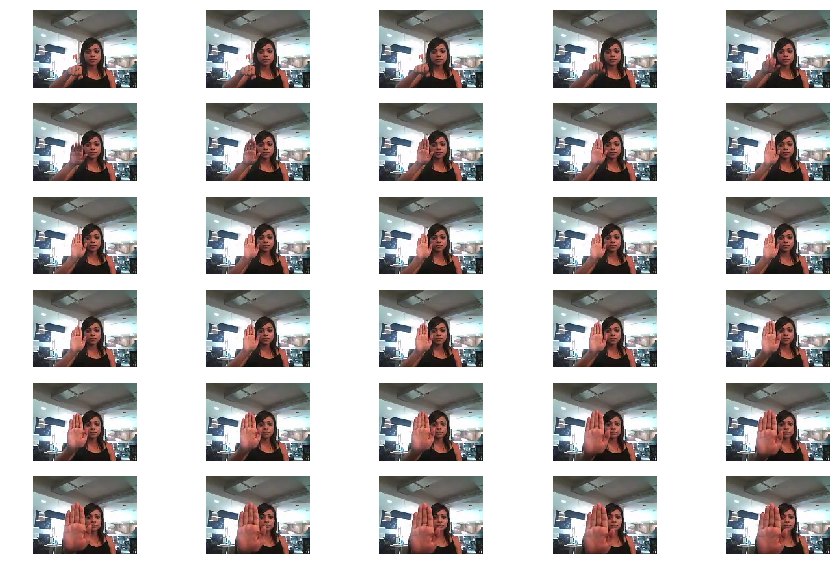

In [11]:
data,data_label=predict_input_image(img_height_Conv3d, img_width_Conv3d)

In [13]:
print({"Left Swipe": 0, "Right Swipe": 1, "Stop": 2, "Thumbs Down": 3, "Thumbs Up": 4})
print("Actual: ", data_label)
from datetime import datetime
start_time = datetime.now()
print("Predicted: ", val_model.predict(data))
end_time = datetime.now()
print('\n \n')
print('Prediction Time: {}'.format(end_time - start_time))

{'Left Swipe': 0, 'Right Swipe': 1, 'Stop': 2, 'Thumbs Down': 3, 'Thumbs Up': 4}
Actual:  [[0. 0. 1. 0. 0.]]
Predicted:  [[2.9753317e-05 1.7941400e-05 9.9933112e-01 8.3715929e-07 6.2042230e-04]]

 

Prediction Time: 0:00:00.012446


##### Prediction using CNN+RNN model where accuracy is (Train: 0.9643, Test: 0.9500)

In [15]:
val_model = model_cnnrnn
# load the saved model-weights
val_model.load_weights('Other_Model/model-00028-0.17369-0.96380-0.24845-0.95000.h5')

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Project_data/train/WIN_20180925_18_15_50_Pro_Thumbs_Down_new/


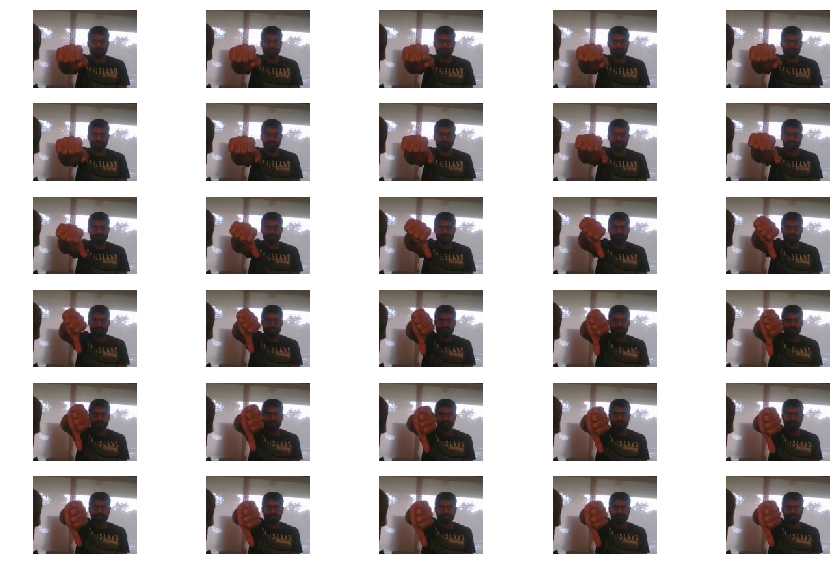

In [16]:
data,data_label=predict_input_image(img_height_CNN_RNN, img_width_CNN_RNN)

In [17]:
print({"Left Swipe": 0, "Right Swipe": 1, "Stop": 2, "Thumbs Down": 3, "Thumbs Up": 4})
print("Actual: ", data_label)
from datetime import datetime
start_time = datetime.now()
print("Predicted: ", val_model.predict(data))
end_time = datetime.now()
print('\n \n')
print('Prediction Time: {}'.format(end_time - start_time))

{'Left Swipe': 0, 'Right Swipe': 1, 'Stop': 2, 'Thumbs Down': 3, 'Thumbs Up': 4}
Actual:  [[0. 0. 0. 1. 0.]]
Predicted:  [[0.00630148 0.0035397  0.00467043 0.9806215  0.00486691]]

 

Prediction Time: 0:00:02.654357


### Conclusion

WE have used following three parameters to conclude which model to be used.

1. The number of parameters and prediction time (reflex time in this case)  -

    Conv3D -
    Trainable params: 2,935,493
    Prediction time - 00.012446 Sec (i.e. 0.012 milliseconds)

    CNN+RNN -
    Trainable params: 4,829,701
    Prediction time - 02.654357


    Clearly the number of parameters and prediction time both are significantly less for Conv3D.
    Note that prediction time here is the reflex time of TV once gesture is made. This reflex time should be as less as
    possible to have smooth operations. 



2. The Accuracy of the model - 

    Conv3D -    
    Train accuracy: 97.26%     
    Validationl accuracy: 91.00%

    CNN+RNN -    
    Train accuracy: 96.43%     
    Validation accuracy: 95.00%

    The accuracy (train and validation) for CNN+RNN are only slightly better than the Conv3D. 
    
  

3. Memory usage - 

    Conv3D - 
    Model Size - 23.5 MB

    CNN+RNN - 
    Model size - 97.6 MB

    Model size of the Conv3D is less which makes it preferrable to be used for TV as it will consure less memory. 

####   Since Conv3D prediction is way faster than the CNN+RNN so we prefer Conv3D so tht the reflex time of the TV to hand gesture is fast. Having a fast reflex is key for the  smooth operations.
